In [1]:
import sys


sys.path.append("../src/")

In [47]:
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm


# root = Path("/home/clay/research/kaggle/sennet/data_dumps/processed_2d/kidney_1_dense")
root = Path("/home/clay/research/kaggle/sennet/data_dumps/processed_2d/kidney_2")
mask_paths = sorted(list(root.glob("*mask*")))
print(len(mask_paths))

111


In [24]:
for p in mask_paths:
    mask = cv2.imread(str(p), 0)
    contours, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    max_contour = 0
    for c in contours:
        a = cv2.contourArea(c)
        if a > max_area:
            max_contour = c
            max_area = a
    # print(max_area)
    if max_area < 1e-3:
        continue
    hull = cv2.convexHull(max_contour)
    new_mask = cv2.drawContours(np.zeros_like(mask), [hull], 0, 255, -1)
    cv2.imwrite(str(p), new_mask)
    # break

In [24]:
margin = 10

# p = mask_paths[10]
# p = mask_paths[50]

for p in tqdm(mask_paths):
    mask = cv2.imread(str(p), 0)
    # plt.imshow(mask)
    
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(mask, 8)
    xs = stats[:, cv2.CC_STAT_LEFT]
    ys = stats[:, cv2.CC_STAT_TOP]
    ws = stats[:, cv2.CC_STAT_WIDTH]
    hs = stats[:, cv2.CC_STAT_HEIGHT]
    areas = stats[:, cv2.CC_STAT_AREA]
    take_mask = (
        (xs > margin)
        & (ys > margin)
        & (mask.shape[1] - (xs + ws) > margin)
        & (mask.shape[0] - (ys + hs) > margin)
    )
    take_indices = np.nonzero(take_mask)[0]
    if len(take_indices) == 0:
        new_mask = np.zeros_like(mask) 
    else:
        max_area_local_idx = np.argmax(areas[take_indices])
        max_area_idx = take_indices[max_area_local_idx]
        max_area_mask = ((labels == max_area_idx) * 255).astype(np.uint8)
        contours, _ = cv2.findContours(max_area_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        max_area = -1
        max_contour = 0
        for c in contours:
            a = cv2.contourArea(c)
            if a > max_area:
                max_contour = c
                max_area = a
        if max_area < 1e-3:
            new_mask = np.zeros_like(mask)
        else:
            hull = cv2.convexHull(max_contour)
            new_mask = cv2.drawContours(np.zeros_like(mask), [hull], 0, 255, -1)
    cv2.imwrite(str(p), new_mask)
        # print(f"{max_area_idx = }")
        # plt.figure()
        # plt.imshow(max_area_mask)
        # plt.figure()
        # plt.imshow(out_mask)

# print(stats)
# print(take_mask)
# print(take_indices)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 114/114 [00:01<00:00, 110.76it/s]


In [35]:
labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)

In [48]:
from scipy.signal import find_peaks

means = []
for p in mask_paths:
    means.append((cv2.imread(str(p), 0) > 0).mean())
means = np.array(means)

peaks, _ = find_peaks(-means, distance=float(0.2*len(means)))
front_peaks = peaks[peaks <= 0.5*len(means)]
rear_peaks = peaks[peaks > 0.5*len(means)]
front_peak = None
end_peak = None
if len(front_peaks) > 0:
    front_peak = front_peaks[np.argmin(means[front_peaks])]
    if means[front_peak] > means[0]:
        front_peak = None
if len(rear_peaks) > 0:
    rear_peak = rear_peaks[np.argmin(means[rear_peaks])]
    if means[rear_peak] > means[-1]:
        rear_peak = None
print(front_peak, rear_peak)

1 None


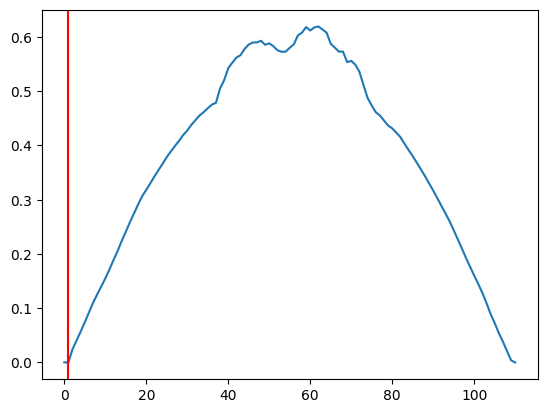

In [49]:
plt.plot(means)
if front_peak is not None:
    plt.axvline(front_peak, color="red")
if rear_peak is not None:
    plt.axvline(rear_peak, color="red")

In [38]:
peaks

(array([ 3, 46, 67, 96]), {})